In [ ]:
# Load the data into a data frame.

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

data = pd.read_csv("rocketfuel_deciles.csv")
data.head()

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour,tot_impr_decile
0,1391842,1,0,2,3,19,2
1,1215269,1,0,1,4,12,1
2,1604030,1,0,2,6,11,2
3,1278452,1,0,1,7,18,1
4,1363432,1,0,1,6,13,1


In [ ]:
# Test balance and Calculate means and standard deviations by test status
balance_table = data.groupby('test').agg(
    count=('tot_impr', 'count'),
    mean_tot_impr=('tot_impr', 'mean'),
    std_tot_impr=('tot_impr', 'std'),
    mean_mode_impr_day=('mode_impr_day', 'mean'),
    std_mode_impr_day=('mode_impr_day', 'std'),
    mean_mode_impr_hour=('mode_impr_hour', 'mean'),
    std_mode_impr_hour=('mode_impr_hour', 'std'),
    mean_tot_impr_decile=('tot_impr_decile', 'mean'),
    std_tot_impr_decile=('tot_impr_decile', 'std')
).reset_index()

# Display the balance table
balance_table

,test,count,mean_tot_impr,std_tot_impr,mean_mode_impr_day,std_mode_impr_day,mean_mode_impr_hour,std_mode_impr_hour,mean_tot_impr_decile,std_tot_impr_decile
0,0,23524,24.761138,42.860720,3.952644,1.948943,14.304923,4.656239,5.325030,2.922811
1,1,564577,24.823365,43.750456,4.028570,2.006226,14.475900,4.841808,5.453194,2.859762


          mean       sem  error_bar        lb        ub
test                                                   
0     0.017854  0.000863   0.001692  0.016162  0.019546
1     0.025547  0.000210   0.000412  0.025135  0.025958


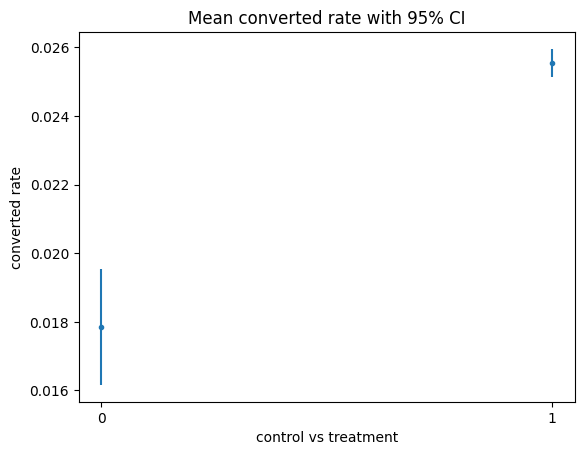

In [ ]:
# Plot outcome: Plot the means and confidence intervals of the main outcome “converted,” treatment status
def make_ate_table(data, outcome, out_cols):
  table = data.groupby("test")[outcome].agg(
        mean = 'mean' ,
        std = 'std' ,
        N = 'count',
        sem = "sem")

  # Confidence intervals
  table['lb'] = table['mean'] - 1.96 * table['sem']
  table['ub'] = table['mean'] + 1.96 * table['sem']
  table["error_bar"] = table["sem"]*1.96

  # ATE calculation: difference between treatment and control means
  table['ate'] = table['mean'] - table['mean'][0]
  table['ate_lift'] = (table['ate']/table['mean'][0]) * 100  # Lift as a percentage
  table['se_ate'] = np.sqrt(table['sem']**2 + table['sem'][0]**2)
  table['ate_lb'] = table['ate'] - 1.96 * table['se_ate']
  table['ate_ub'] = table['ate'] + 1.96 * table['se_ate']
  table["ate_error_bar"] = table["se_ate"]*1.96

  return table[out_cols]

out_cols = ["mean", "sem", "error_bar", "lb", "ub"]
table = make_ate_table(data, "converted", out_cols)
print(table)

plt.figure()
plt.errorbar(table.index, table["mean"], fmt = ".", yerr=table["error_bar"])
plt.xlabel('control vs treatment')
plt.ylabel('converted rate')
plt.title('Mean converted rate with 95% CI')
plt.xticks([0, 1])
plt.show()

In [ ]:
# Find ATE: Estimate of the Average Treatment Effect (ATE) of the ads for treatment relative to control
out_cols = ["mean", "ate", "se_ate", "lb", "ub"]
table = make_ate_table(data, "converted", out_cols)
print(table)

          mean       ate    se_ate        lb        ub
test                                                  
0     0.017854  0.000000  0.001221  0.016162  0.019546
1     0.025547  0.007692  0.000889  0.025135  0.025958


In [ ]:
# Subgroup analysis: Create a summary table showing the treatment effect in each decile.
for decile in data['tot_impr_decile'].unique():
  decile_data = data[data['tot_impr_decile'] == decile]
  print("\n", "decile", decile)
  out_cols = ["mean", "ate", "ate_lift", "ate_lb", "ate_ub"]
  print(make_ate_table(decile_data, 'converted', out_cols))


 decile 2
          mean       ate   ate_lift    ate_lb    ate_ub
test                                                   
0     0.002155  0.000000   0.000000 -0.002255  0.002255
1     0.002575  0.000421  19.523598 -0.001221  0.002062

 decile 1
          mean       ate  ate_lift    ate_lb    ate_ub
test                                                  
0     0.001300  0.000000   0.00000 -0.002079  0.002079
1     0.001584  0.000284  21.85102 -0.001224  0.001792

 decile 3
          mean       ate   ate_lift    ate_lb    ate_ub
test                                                   
0     0.005208  0.000000   0.000000 -0.004158  0.004158
1     0.003431 -0.001777 -34.127913 -0.004761  0.001206

 decile 4
          mean       ate   ate_lift    ate_lb    ate_ub
test                                                   
0     0.005622  0.000000   0.000000 -0.004154  0.004154
1     0.004210 -0.001412 -25.114118 -0.004398  0.001574

 decile 5
          mean       ate  ate_lift    ate_lb    ate_u

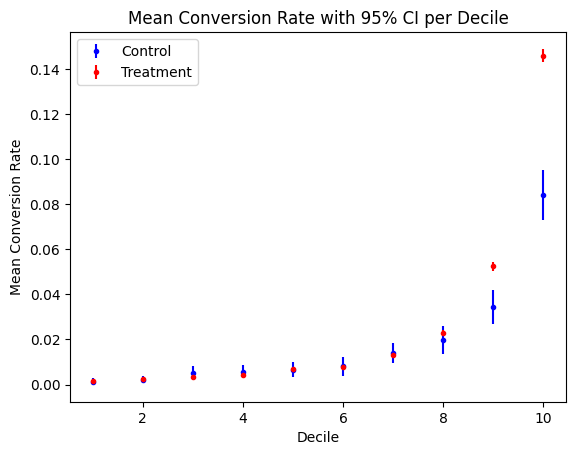

In [ ]:
# subgroup plots – means + CI: Create a graph that shows the mean and 95% CI on “converted” separately for treatment and control plotted over the 10 deciles of total impressions
decile_stats = []

for decile in data['tot_impr_decile'].unique():
    decile_data = data[data['tot_impr_decile'] == decile]
    out_cols = ["mean", "error_bar", "ate_error_bar", "ate"]
    stats = make_ate_table(decile_data, 'converted', out_cols)
    stats['decile'] = decile
    decile_stats.append(stats)

decile_stats_df = pd.concat(decile_stats).reset_index()

# Separate treatment and control data
control_data = decile_stats_df[decile_stats_df['test'] == 0]
treatment_data = decile_stats_df[decile_stats_df['test'] == 1]

# Plot mean conversion rates treatment and control groups
plt.figure()
plt.errorbar(control_data['decile'], control_data['mean'], yerr=control_data['error_bar'],
             fmt='.', color='blue', label='Control')
plt.errorbar(treatment_data['decile'], treatment_data['mean'], yerr=treatment_data['error_bar'],
             fmt='.', color='red', label='Treatment')

plt.xlabel('Decile')
plt.ylabel('Mean Conversion Rate')
plt.title('Mean Conversion Rate with 95% CI per Decile')
plt.legend()
plt.show()

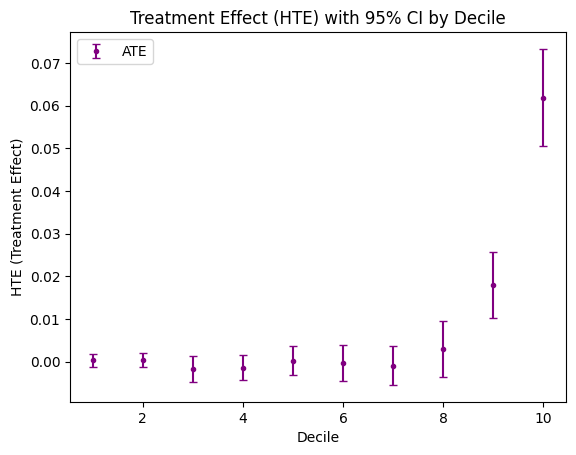

In [ ]:
# Plot treatment effect (HTE) with 95% CI for each decile
plt.figure()
plt.errorbar(treatment_data['decile'], treatment_data['ate'], yerr=(treatment_data["ate_error_bar"]),
             fmt='.', color='purple', label='ATE', capsize=3)

plt.xlabel('Decile')
plt.ylabel('HTE (Treatment Effect)')
plt.title('Treatment Effect (HTE) with 95% CI by Decile')
plt.legend()
plt.show()

In [ ]:
# Define the markup per sale and ad spending per person in treatment
markup_per_sale = 40

impressions_sold = 14500000
cost_per_impression = 9
users = 590000
ad_spending_per_person = ((impressions_sold/1000)* cost_per_impression) / users

out_cols = ["mean", "ate"]
table = make_ate_table(data, 'converted', out_cols)
# Use the ATE calculated in previous analysis
ate_on_conversions = table.loc[1, 'ate']  # ATE from treatment effect table

# Calculate return on advertising
return_on_advertising = (ate_on_conversions * markup_per_sale) / ad_spending_per_person

# Output result
print("Overall Return on Advertising Spending:", return_on_advertising)

Overall Return on Advertising Spending: 1.391125634758282


In [ ]:
# Define constants from case study

returns_by_decile = []

# Iterate over each decile
for decile in data['tot_impr_decile'].unique():
    # Filter data for the current decile
    decile_data = data[data['tot_impr_decile'] == decile]

    # Calculate ATE for the decile
    table = make_ate_table(decile_data, 'converted', ['mean', 'ate'])
    ate_on_conversions = table.loc[1, 'ate']  # ATE for the treatment group

    # Calculate return on advertising for the decile
    return_on_advertising = (ate_on_conversions * markup_per_sale) / ad_spending_per_person
    returns_by_decile.append((decile, return_on_advertising))

# Filter deciles with positive return
positive_returns = [(dec, ret) for dec, ret in returns_by_decile if ret > 0]

# Calculate the total return if only targeting positive-return deciles
total_targeted_return = sum(ret for dec, ret in positive_returns)

# Output results
print("Return by Decile:", returns_by_decile)
print("Targeted Return on Advertising (Positive Deciles Only):", total_targeted_return)


Return by Decile: [(2, 0.07606934440128917), (1, 0.05136397781665491), (3, -0.3214474539846806), (4, -0.25535720169451004), (5, 0.030060284947919444), (6, -0.051668815557086634), (7, -0.1724248223971868), (8, 0.5306707865175926), (9, 3.243106262683293), (10, 11.189671288736383)]
Targeted Return on Advertising (Positive Deciles Only): 15.120941945103132
